In [12]:
########################################
# packages used in this script         
########################################

import numpy as np
import pandas as pd
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import random
import pickle
import matplotlib.pyplot as plt
import sys
import os
import csv
csv.field_size_limit(sys.maxsize)

from bs4 import BeautifulSoup as bs

In [13]:
###############################################################################################################################
# Function: data_preprocessing()                                
# Param:                                               
#     - ma_path (str): the path to the M&A news data file(s).
#     - general_path (str): the path to the general news data file(s).
# Return:
#     - maNews (list): the list of pre-processed M&A news articles.
#     - generalNews (list): the list of pre-processed general news articles.
###############################################################################################################################

def data_preprocessing(ma_path, general_path):
    # pre-processing M&A news
    ma_news = pd.read_csv(ma_path, engine='python', error_bad_lines=False)
    ma_news = ma_news.to_numpy()
    
    maNews = []
    for row in ma_news:
        temp_text = row[3]

        if type(temp_text) is not float:
            soup = bs(temp_text, "html.parser")
            cur_text = soup.findAll('bodytext')[0]

            maNews.append(cur_text.text)
            
    # pre-processing general news
    generalNews = []
    directory = "data collection/NewData"
    for root,dirs,files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                try:
                    print(file)
                    data = pd.read_csv(directory + "/" + file, engine='python', error_bad_lines=False)
                    data = data.to_numpy()

                    for row in data:
                        context = row[1]

                        try:
                            soup = bs(row[1], "html.parser")
                            text = soup.findAll('bodytext')

                            output_string = ""
                            for t in text:
                                inside_text = t.findAll('text')
                                for t in inside_text:
                                    output_string = output_string + " " + t.text

                            available_text = True

                            for i in range(len(output_string)-5):
                                if output_string[i:i+5] == "merge":
                                    available_text = False
                                    break

                                if output_string[i:i+5] == "acqui":
                                    available_text = False
                                    break

                            if available_text == True:
                                generalNews.append(output_string)
                        except:
                            continue

                except:
                    continue
    
    return maNews, generalNews

In [14]:
###############################################################################################################################
# Function: train_test_split()                                
# Param:                                               
#     - maNews (list): the list of pre-processed M&A news articles.
#     - generalNews (list): the list of pre-processed general news articles.
# Return:
#     - ma_train_news (nparray): the list of M&A news in training data set.
#     - ma_test_news (nparray): the list of M&A news in test data set.
#     - general_train_news (nparray): the list of general news in training data set.
#     - general_test_news (nparray): the list of general news in test data set.
###############################################################################################################################

def train_test_split(maNews, generalNews):
    # change the train test split ratio here (currently the ratio is 0.8)
    general_train_number = int(len(generalNews)*0.8)
    ma_train_number = int(len(maNews)*0.8)

    general_train_news = random.sample(list(generalNews), general_train_number)
    general_test_news = []
    for item in generalNews:
        if item not in general_train_news:
            general_test_news.append(item)

    ma_train_news = random.sample(list(maNews), ma_train_number)
    ma_test_news = []
    for item in maNews:
        if item not in ma_train_news:
            ma_test_news.append(item)
            
    return ma_train_news, ma_test_news, general_train_news, general_test_news

In [15]:
###############################################################################################################################
# Function: random_sampling()                                
# Param:                                               
#     - ma_train_news (nparray): the list of M&A news in training data set.
#     - ma_test_news (nparray): the list of M&A news in test data set.
#     - general_train_news (nparray): the list of general news in training data set.
#     - general_test_news (nparray): the list of general news in test data set.
# Return:
#     - train_str (list): the list of combined training data set. It contains both general news and M&A news.
#     - test_str (list): the list of combined test data set. It contains both general news and M&A news.
###############################################################################################################################

def random_sampling(ma_train_news, ma_test_news, general_train_news, general_test_news):
    train_str = []
    rand_list = random.sample(range(0, len(general_train_news)), len(ma_train_news))
    
    for i in range(len(general_train_news)):
        if i in rand_list:
            train_str.append(general_train_news[i])

    for item in ma_train_news:
        train_str.append(item)

    test_str = []
    rand_list_test = random.sample(range(0, len(general_test_news)), len(ma_test_news))
    
    for i in range(len(general_test_news)):
        if i in rand_list_test:
            test_str.append(general_test_news[i])

    for item in ma_test_news:
        test_str.append(item)

    return train_str, test_str

In [16]:
################################################################################################################################
# Function: train_LDA()
# Param:
#     - train_str (list): the list of news articles in the training data set.
# Return:
#     - lda (model): the trained LDA model with mixed training news article.
#     - cv (model): the trained CountVectorizer model with mixed training news article.
################################################################################################################################

def train_LDA(train_str):
    start_time = time.time()

    cv = CountVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')
    df_train = cv.fit_transform(train_str[:])

    lda = LatentDirichletAllocation(n_components=10)
    lda.fit(df_train)

    print("running time: " + str(time.time()-start_time))
    return cv, lda

In [17]:
################################################################################################################################
# Function: print_topics()
# Param:
#     - lda (model): the trained LDA model returned from train_LDA() function.
#     - cv (model): the trained CountVectorizer model returned from train_LDA() function.
# Return:
#     - None
# Topics are printed in the stdout window
################################################################################################################################

def print_topics(lda, cv):
    for index, topic in enumerate(lda.components_):
        print(f'Top 15 words for Topic #{index}')
        print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
        print('\n')

In [18]:
################################################################################################################################
# Function: plot_pattern_training()
# Param:
#     - ma_train_news (nparray): the list of M&A news in training data set.
#     - train_str (list): the list of news articles in the training data set.
#     - lda (model): the trained LDA model returned from train_LDA() function.
#     - cv (model): the trained CountVectorizer model returned from train_LDA() function.
# Return:
#     - None
# Figure is plotted
################################################################################################################################

def plot_pattern_training(ma_train_news, train_str, lda, cv):
    general_result = [0 for i in range(10)]
    ma_result = [0 for i in range(10)]
    df1 = cv.transform(train_str[:])
    prob = lda.transform(df1)

    for index, item in enumerate(prob):
        temp_prob = item

        max_topic = 0
        max_prob = temp_prob[0]

        for i in range(1, len(temp_prob)):
            if temp_prob[i] > max_prob:
                max_topic = i
                max_prob = temp_prob[i]

        if index < len(ma_train_news):
            general_result[max_topic] += 1
        else:
            ma_result[max_topic] += 1
            
    # plot topics on training data set
    x = np.linspace(0,10,10)

    plt.bar(x-0.2, general_result, 0.4, color='blue', label='general')
    plt.bar(x+0.2, ma_result, 0.4, color='purple', label='m&a')
    plt.xticks(x, ('T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9'))
    plt.legend()
    plt.xlabel('topics')
    plt.ylabel('# of news')
    plt.title('Training Data Set')
    plt.show()

In [19]:
################################################################################################################################
# Function: plot_pattern_test()
# Param:
#     - ma_test_news (nparray): the list of M&A news in training data set.
#     - test_str (list): the list of news articles in the training data set.
#     - lda (model): the trained LDA model returned from train_LDA() function.
#     - cv (model): the trained CountVectorizer model returned from train_LDA() function.
# Return:
#     - None
# Figure is plotted
################################################################################################################################

def plot_pattern_test(ma_test_news, test_str, lda, cv):
    general_result_test = [0 for i in range(10)]
    ma_result_test = [0 for i in range(10)]
    df2 = cv.transform(test_str[:])
    prob_test = lda.transform(df2)

    for index, item in enumerate(prob_test):
        temp_prob = item

        max_topic = 0
        max_prob = temp_prob[0]

        for i in range(1, len(temp_prob)):
            if temp_prob[i] > max_prob:
                max_topic = i
                max_prob = temp_prob[i]

        if index < len(ma_test_news):
            general_result_test[max_topic] += 1
        else:
            ma_result_test[max_topic] += 1
            
    # plot topics on test data set
    x_test = np.linspace(0,10,10)

    plt.bar(x_test-0.2, general_result_test, 0.4, color='blue', label='general')
    plt.bar(x_test+0.2, ma_result_test, 0.4, color='purple', label='m&a')
    plt.xticks(x_test, ('T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9'))
    plt.legend()
    plt.xlabel('topics')
    plt.ylabel('# of news')
    plt.title('Testing Data Set')
    plt.show()

Code starting...
ADVANCE AMERICA CASH ADVANCE CENTERS INC_20101011-20111011.csv
AFFILIATED MANAGERS GROUP_20090415-20100415.csv
ALLIANCEBERNSTEIN HOLDING L.P._20121212-20131212.csv


Skipping line 336: unexpected end of data


AMERIPRISE FINANCIAL_20110120-20120120.csv
APOLLO COMMERCIAL REAL ESTATE FINANCE INC_20150903-20160902.csv
APOLLO GLOBAL MANAGEMENT INC_20150903-20160902.csv
APOLLO GLOBAL MANAGEMENT INC_20180620-20190620.csv
APOLLO RESIDENTIAL MORTGAGE INC_20150903-20160902.csv
ARES MANAGEMENT CORP_20180620-20190620.csv
BGC PARTNERS_20070617-20080616.csv
BLACKSTONE GROUP INC_20150506-20160505.csv
CARLYLE GROUP INC_20120423-20130423.csv
CASH STORE FINANCIAL SERVICES_20140206-20150206.csv
CBOE GLOBAL MARKETS INC_20160301-20170301.csv
CBOT HOLDINGS_20070123-20080123.csv
CENTRAL GOLDTRUST_20150125-20160125.csv
CME GROUP_20070123-20080123.csv
CME GROUP_20070807-20080806.csv
CME GROUP_20071108-20081107.csv
CONSUMER CAPITAL GROUP_20100405-20110405.csv
COWEN INC._20100630-20110630.csv
DFC GLOBAL_20100412-20110412.csv
DISCOVER FINANCIAL SERVICES_20100323-20110323.csv
DISCOVER FINANCIAL SERVICES_20110608-20120607.csv
DITECH HOLDING CORP_20120220-20130219.csv
DUFF & PHELPS CORP_20120423-20130423.csv
Edmond de Ro

Skipping line 16345: unexpected end of data


MR. AMAZING LOANS CORP_20160623-20170623.csv
MR. COOPER GROUP INC_20170801-20180801.csv
NASDAQ INC_20080227-20090226.csv
NASDAQ INC_20120808-20130808.csv
NATIONAL HOLDINGS CORP_20121021-20131021.csv
NATIONAL HOLDINGS_20070703-20080702.csv
NATIONAL MONEY MART CO_20140206-20150206.csv
NATIONSTAR MORTGAGE HOLDINGS INC_20170801-20180801.csv
NEW RESIDENTIAL INVESTMENT CORP_20150506-20160505.csv
NOMURA HOLDINGS_20071202-20081201.csv
North Island_20160721-20170721.csv
NYMEX HOLDINGS_20071108-20081107.csv
NYSE EURONEXT_20070807-20080806.csv
NYSE EURONEXT_20121113-20131113.csv
OAKTREE CAPITAL GROUP LLC_20161017-20171017.csv
OCWEN FINANCIAL CORP_20120101-20121231.csv
OCWEN FINANCIAL CORP_20120220-20130219.csv
OCWEN FINANCIAL CORP_20120708-20130708.csv
OCWEN FINANCIAL_20101004-20111004.csv
OCWEN FINANCIAL_20110505-20120504.csv
ONEMAIN HOLDINGS INC_20150506-20160505.csv
ONEMAIN HOLDINGS INC_20160623-20170623.csv
OPTIONSXPRESS HOLDINGS_20100901-20110901.csv
PENSON WORLDWIDE_20110612-20120611.csv
Pi

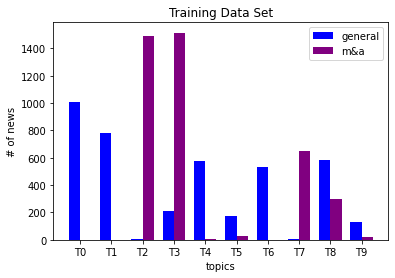

Start to plot patterns in test data set...


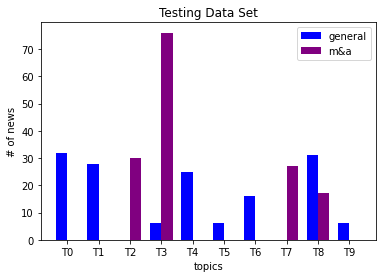

Code finishing...


In [20]:
def main():
    print("Code starting...")
    # define path to data file. (In local machine, this jupyter notebook is in the same level with folder "data collection")
    ma_path = "data collection/M&A_News.csv"
    general_path = "data collection/NewData"
    
    # processing news article for both M&A news and general news, and save news articles to the lists.
    maNews, generalNews = data_preprocessing(ma_path, general_path)
    print("Finish data preprocessing...")
    
    # split 80% of both general news and M&A news to training data set, and rest 20% to test data set.
    ma_train_news, ma_test_news, general_train_news, general_test_news = train_test_split(maNews, generalNews)
    print("Finish train test split...")
    
    # since number of general news and M&A news differ too much, the random sampling applied to the general news.
    train_str, test_str = random_sampling(ma_train_news, ma_test_news, general_train_news, general_test_news)
    print("Finish random sampling...")
    
    # train LDA model with train data set
    cv, lda = train_LDA(train_str)
    print("Finish training LDA model...")
    
    # print topics
    print("Start to print topics and words...")
    print_topics(lda, cv)
    
    # plot patterns in the training data set
    print("Start to plot patterns in training data set...")
    plot_pattern_training(ma_train_news, train_str, lda, cv)
    
    # plot patterns in the test data set
    print("Start to plot patterns in test data set...")
    plot_pattern_test(ma_test_news, test_str, lda, cv)
    
    print("Code finishing...")
    
if __name__ == "__main__":
    main()